Este archivo principal une todos los módulos y ejecuta el entrenamiento, validación y evaluación del modelo GCN.

In [1]:

#Importamos los modulos necesarios

import torch
import numpy as np
from torch_geometric.loader import DataLoader
from Dataset_loader import PCBDataset  # Asegúrate que Dataset_loader se encuentra en el mismo directorio
from gcn_model import GCN
from data_loader import load_pcb_dataset
from train_eval import train, evaluate, plot_temperature_maps, standardize_data
from model_saver import save_model
import os
help(save_model)

Help on function save_model in module model_saver:

save_model(model, num_layers, hidden_dim, epochs, learning_rate, test_mse, test_accuracy)
    Guarda un modelo GCN con un nombre que incluye su estructura, hiperparámetros y rendimiento.

    Args:
        model (torch.nn.Module): El modelo GCN entrenado.
        num_layers (int): Número de capas en el modelo GCN.
        hidden_dim (int): Dimensión de las capas ocultas.
        epochs (int): Número total de épocas de entrenamiento.
        learning_rate (float): Tasa de aprendizaje utilizada durante el entrenamiento.
        test_mse (float): Error medio cuadrático (MSE) en el conjunto de prueba.
        test_accuracy (float): Porcentaje de aciertos dentro del umbral de error.



In [2]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mostrar mensaje de inicio
print("Iniciando el script...")
print(f"Usando dispositivo: {device}")

Iniciando el script...
Usando dispositivo: cuda


In [3]:
# Ruta al archivo de dataset
file_path = 'PCB_dataset.pth'  # Asegúrate que este archivo está en la carpeta actual

# Cargar el dataset y estandarizarlo automáticamente
graphs = standardize_data(load_pcb_dataset(file_path))  # Ahora la estandarización se realiza automáticamente

# Imprimir información del dataset
print(f"Dataset cargado correctamente. Número de gráficos: {len(graphs)}")
nodos_por_grafico = graphs[0].y.shape[0]  # Obtiene el número total de nodos por gráfico
print(f"Número de nodos por gráfico: {nodos_por_grafico}")



c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\Repo_TFG\ia_thermal\ernestoemedina\data_loader.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = to

Dataset cargado correctamente. Número de gráficos: 20000
Número de nodos por gráfico: 169


In [4]:
# División del dataset
train_size = int(0.8 * len(graphs))
val_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - val_size

train_dataset = graphs[:train_size]
val_dataset = graphs[train_size:train_size + val_size]
test_dataset = graphs[train_size + val_size:]

# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# Definición del modelo
input_dim = 1  # Potencia como única característica de entrada
hidden_dim = 64
output_dim = 1  # Temperatura predicha por cada nodo
num_layers = 3
learning_rate = 0.001
epochs = 10

# Crear el modelo
model = GCN(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Modelo creado correctamente.")


Modelo creado correctamente.


In [9]:
# Entrenamiento del modelo
print("Iniciando entrenamiento...")
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, device)
    val_mse, val_mae, val_r2, val_accuracy = evaluate(
    model, test_loader, device, nodos_por_grafico=nodos_por_grafico, plot_results=False, normalize=True
)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val MSE: {val_mse:.4f} - Val MAE: {val_mae:.4f} - Val R2: {val_r2:.4f} - Val Accuracy: {val_accuracy:.2f}%")


Iniciando entrenamiento...
Epoch 1/10 - Loss: 0.4858 - Val MSE: 0.3994 - Val MAE: 0.5003 - Val R2: 0.3248 - Val Accuracy: 17.35%
Epoch 2/10 - Loss: 0.4040 - Val MSE: 0.3962 - Val MAE: 0.4972 - Val R2: 0.3393 - Val Accuracy: 17.44%
Epoch 3/10 - Loss: 0.4003 - Val MSE: 0.3920 - Val MAE: 0.4934 - Val R2: 0.3461 - Val Accuracy: 17.58%
Epoch 4/10 - Loss: 0.3962 - Val MSE: 0.3888 - Val MAE: 0.4923 - Val R2: 0.3459 - Val Accuracy: 17.52%
Epoch 5/10 - Loss: 0.3933 - Val MSE: 0.3888 - Val MAE: 0.4892 - Val R2: 0.3659 - Val Accuracy: 17.84%
Epoch 6/10 - Loss: 0.3915 - Val MSE: 0.3872 - Val MAE: 0.4884 - Val R2: 0.3680 - Val Accuracy: 17.88%
Epoch 7/10 - Loss: 0.3905 - Val MSE: 0.3849 - Val MAE: 0.4864 - Val R2: 0.3533 - Val Accuracy: 17.84%
Epoch 8/10 - Loss: 0.3906 - Val MSE: 0.3844 - Val MAE: 0.4874 - Val R2: 0.3563 - Val Accuracy: 17.78%
Epoch 9/10 - Loss: 0.3900 - Val MSE: 0.3863 - Val MAE: 0.4914 - Val R2: 0.3432 - Val Accuracy: 17.53%
Epoch 10/10 - Loss: 0.3899 - Val MSE: 0.3845 - Val MAE:

Evaluando en el conjunto de prueba...


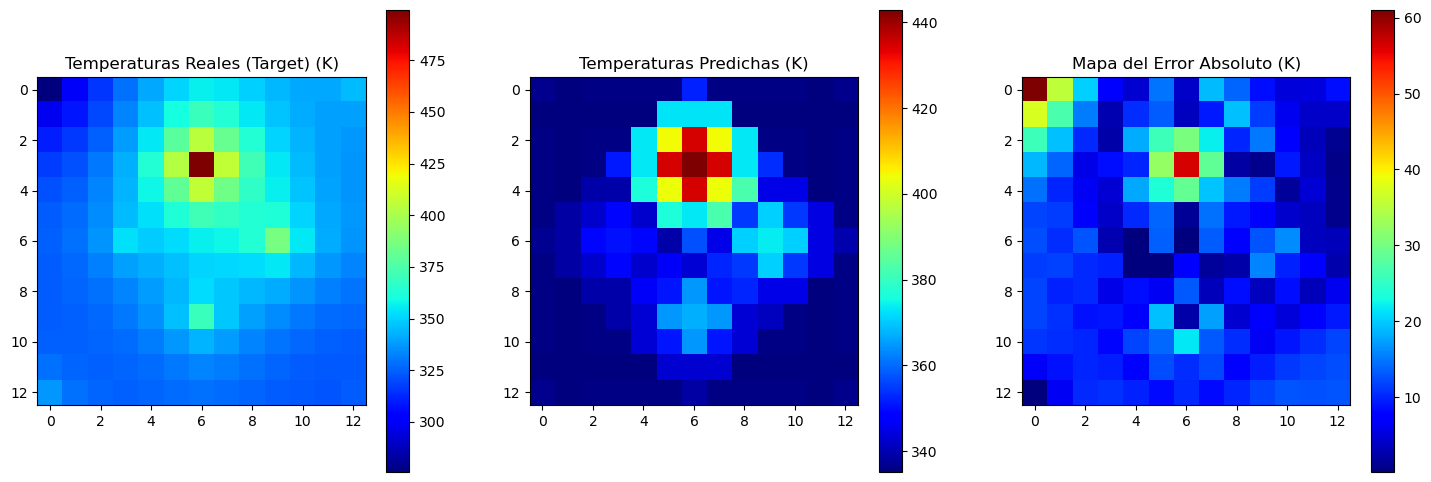

Test MSE: 496.0504 - Test MAE: 17.4493 - Test R2: 0.3563
Porcentaje de nodos de todos los graficos correctamente predichos dentro de un error de ±5.0 K: 17.86%


' save_model(model, num_layers=num_layers, hidden_dim=hidden_dim, \n           epochs=epochs, learning_rate=learning_rate,\n           test_mse=test_mse, test_accuracy=test_accuracy) '

In [ ]:
# Evaluación en el conjunto de prueba
print("Evaluando en el conjunto de prueba...")
error_threshold_K = 5.0  # Cambia esto al valor que desees en Kelvin

#Programar error en %, en el que tu metas el porcentaje de error que quieres que tenga el modelo por nodo para calificarlo como "valido"

test_mse, test_mae, test_r2, test_accuracy = evaluate(
    model, test_loader, device, nodos_por_grafico=nodos_por_grafico, error_threshold=error_threshold_K, plot_results=True, normalize=False
)


print(f"Test MSE: {test_mse:.4f} - Test MAE: {test_mae:.4f} - Test R2: {test_r2:.4f}")
print(f"Porcentaje de nodos de todos los graficos correctamente predichos dentro de un error de ±{error_threshold_K} K: {test_accuracy:.2f}%")


# Guardar el modelo con todos los detalles relevantes
""" save_model(model, num_layers=num_layers, hidden_dim=hidden_dim, 
           epochs=epochs, learning_rate=learning_rate,
           test_mse=test_mse, test_accuracy=test_accuracy) """


Si quisieramos predecir las temperaturas sin tener un target, pero si un archivo con las condiciones de contorno, compilariamos el siguiente bloque de código.

In [ ]:
from train_eval import predict  # Asegúrate que la función predict() está disponible

# Cargar las condiciones de contorno (sin target)
conditions = load_pcb_dataset('conditions.pth') # Asegúrate que el archivo 'conditions.pth' está en la carpeta actual
conditions_loader = DataLoader(conditions, batch_size=32, shuffle=False)

# Generar predicciones
predictions = predict(model, conditions_loader, device, nodos_por_grafico=nodos_por_grafico, normalize=False)

# Guardar las predicciones si lo deseas
torch.save(predictions, "Predicciones_Condiciones.pth")
print("Predicciones generadas y guardadas correctamente.")

plot_temperature_maps(predictions[0])  # Cambiar el índice si deseas visualizar otro gráfico

